<a href="https://colab.research.google.com/github/jhkang0516/dialect_classification/blob/main/GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd '/content/drive/MyDrive/Colab Notebooks/TeamProject/'

/content/drive/MyDrive/Colab Notebooks/TeamProject


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import librosa
import librosa.display
from IPython.display import Audio
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, LSTM, Bidirectional, GRU, BatchNormalization, LeakyReLU
from keras.utils import to_categorical
import os
import math
import json
import random

# 데이터셋 크기 조정

In [ ]:
# 데이터 로드

dataDir = "/content/drive/MyDrive/2301 기계학습/학습용 데이터/"

X_mfcc_GS = np.load(dataDir + "X_mfcc_경상.npy")
X_mfcc_JR = np.load(dataDir + "X_mfcc_전라.npy")
X_mfcc_JJ = np.load(dataDir + "X_mfcc_제주.npy")

Y_label_GS = np.load(dataDir + "Y_label_경상.npy")
Y_label_JR = np.load(dataDir + "Y_label_전라.npy")
Y_label_JJ = np.load(dataDir + "Y_label_제주.npy")

In [ ]:
# 데이터 크기 확인

print(X_mfcc_GS.shape)
print(X_mfcc_JR.shape)
print(X_mfcc_JJ.shape)

print(Y_label_GS.shape)
print(Y_label_JR.shape)
print(Y_label_JJ.shape)

(10000, 39, 259)
(10000, 39, 259)
(10000, 39, 259)
(10000,)
(10000,)
(10000,)


In [ ]:
# 세 데이터셋 크기 10000으로 맞추기

X_mfcc_JJ = X_mfcc_JJ.tolist()
Y_label_JJ = Y_label_JJ.tolist()

for i in range(len(Y_label_JJ) - 10000):
    random_index = np.random.randint(0, len(Y_label_JJ))

    X_mfcc_JJ.pop(random_index)
    Y_label_JJ.pop(random_index)

X_mfcc_JJ = np.array(X_mfcc_JJ)
Y_label_JJ = np.array(Y_label_JJ)

In [ ]:
# 가공된 데이터셋 저장

np.save("X_mfcc_GS.npy", X_mfcc_GS)
np.save("X_mfcc_JR.npy", X_mfcc_JR)
np.save("X_mfcc_JJ.npy", X_mfcc_JJ)

np.save("Y_label_GS.npy", Y_label_GS)
np.save("Y_label_JR.npy", Y_label_JR)
np.save("Y_label_JJ.npy", Y_label_JJ)

# 데이터셋 병합

In [ ]:
# 데이터 로드

dataDir = "/content/drive/MyDrive/Colab Notebooks/TeamProject/"

X_mfcc_GS = np.load(dataDir + "X_mfcc_GS.npy")
X_mfcc_JR = np.load(dataDir + "X_mfcc_JR.npy")
X_mfcc_JJ = np.load(dataDir + "X_mfcc_JJ.npy")

Y_label_GS = np.load(dataDir + "Y_label_GS.npy")
Y_label_JR = np.load(dataDir + "Y_label_JR.npy")
Y_label_JJ = np.load(dataDir + "Y_label_JJ.npy")

In [ ]:
# 데이터 병합
X_mfcc_ALL = np.vstack((X_mfcc_GS, X_mfcc_JR))
X_mfcc_ALL = np.vstack((X_mfcc_ALL, X_mfcc_JJ))

Y_label_ALL = np.concatenate((Y_label_GS, Y_label_JR))
Y_label_ALL = np.concatenate((Y_label_ALL, Y_label_JJ))

In [ ]:
print(X_mfcc_ALL.shape)
print(Y_label_ALL.shape)

(60000, 39, 259)
(60000,)


In [ ]:
np.save("X_mfcc_ALL.npy", X_mfcc_ALL)
np.save("Y_label_ALL.npy", Y_label_ALL)

# 데이터 전처리

In [ ]:
# 데이터 로드

dataDir = "/content/drive/MyDrive/Colab Notebooks/TeamProject/"

X_mfcc_ALL = np.load(dataDir + "X_mfcc_ALL.npy")
Y_label_ALL = np.load(dataDir + "Y_label_ALL.npy")

In [ ]:
from sklearn.preprocessing import LabelEncoder

# 레이블 인코더 생성
le = LabelEncoder()

# Y_label_ALL을 정수로 변환
Y_label_ALL = le.fit_transform(Y_label_ALL)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# 차원 변환
Y_label_ALL = Y_label_ALL.reshape(-1, 1)

# 원핫 인코더 생성
oe = OneHotEncoder()

# Y_label_ALL을 정수로 변환
Y_label_ALL = oe.fit_transform(Y_label_ALL)

In [ ]:
# 인코딩 결과 확인
Y_label_ALL

array([[0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]])

# 데이터 스플릿

In [ ]:
# 데이터 로드

dataDir = "/content/drive/MyDrive/Colab Notebooks/TeamProject/"

X_mfcc_ALL = np.load(dataDir + "X_mfcc_ALL.npy")
Y_label_ALL = np.load(dataDir + "Y_label_ALL.npy")

In [ ]:
# Sparse to Dense
Y_label_ALL = Y_label_ALL.toarray()

In [ ]:
# 데이터 스플릿

X_train, X_test, Y_train, Y_test = train_test_split(X_mfcc_ALL, Y_label_ALL, test_size=0.2, random_state=42, stratify=Y_label_ALL)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

In [ ]:
# 스플릿 stratify 결과 확인

print(pd.DataFrame(Y_train).value_counts())
print(pd.DataFrame(Y_test).value_counts())
print(pd.DataFrame(Y_test).value_counts())

0    1    2    3    4    5  
0.0  0.0  1.0  0.0  0.0  0.0    6448
          0.0  0.0  0.0  1.0    6430
                    1.0  0.0    6392
1.0  0.0  0.0  0.0  0.0  0.0    6388
0.0  0.0  0.0  1.0  0.0  0.0    6377
     1.0  0.0  0.0  0.0  0.0    6365
dtype: int64
0    1    2    3    4    5  
0.0  0.0  0.0  0.0  0.0  1.0    2000
                    1.0  0.0    2000
               1.0  0.0  0.0    2000
          1.0  0.0  0.0  0.0    2000
     1.0  0.0  0.0  0.0  0.0    2000
1.0  0.0  0.0  0.0  0.0  0.0    2000
dtype: int64
0    1    2    3    4    5  
0.0  0.0  0.0  0.0  0.0  1.0    2000
                    1.0  0.0    2000
               1.0  0.0  0.0    2000
          1.0  0.0  0.0  0.0    2000
     1.0  0.0  0.0  0.0  0.0    2000
1.0  0.0  0.0  0.0  0.0  0.0    2000
dtype: int64


# GRU 모델 구축

In [ ]:
# GPU 체크

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# LSTM
with tf.device('/device:GPU:0'):
    # The LSTM architecture
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=(X_mfcc_ALL.shape[1], X_mfcc_ALL.shape[2])))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(LSTM(200, return_sequences=True))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(LSTM(200, return_sequences=True))
    model.add(LeakyReLU())
    model.add(Flatten())
    model.add(Dense(100))
    model.add(Dropout(0.2))
    model.add(Dense(40))
    model.add(Dropout(0.2))
    model.add(Dense(6, 'softmax'))

    # Compiling the RNN
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss = 'categorical_crossentropy',
                metrics=['accuracy'])

In [ ]:
# GRU
with tf.device('/device:GPU:0'):
    model = Sequential()

    model.add(GRU(100, return_sequences=True, input_shape=(X_mfcc_ALL.shape[1], X_mfcc_ALL.shape[2])))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(GRU(200, return_sequences=True))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(GRU(200))
    model.add(LeakyReLU())
    model.add(Flatten())
    model.add(Dense(100))
    model.add(Dropout(0.2))
    model.add(Dense(20))
    model.add(Dropout(0.2))
    model.add(Dense(6, 'softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss = 'categorical_crossentropy',
                metrics=['accuracy'])

In [ ]:
# Bi-LSTM
with tf.device('/device:GPU:0'):
    # The LSTM architecture
    model = Sequential()
    model.add(Bidirectional(LSTM(units=100, return_sequences=True, input_shape=(X_mfcc_ALL.shape[1], X_mfcc_ALL.shape[2]))))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Bidirectional(LSTM(200, return_sequences=True)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Bidirectional(LSTM(200, return_sequences=True)))
    model.add(LeakyReLU())
    model.add(Flatten())
    model.add(Dense(100))
    model.add(Dropout(0.2))
    model.add(Dense(20))
    model.add(Dropout(0.2))
    model.add(Dense(6, 'softmax'))

    # Compiling the RNN
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss = 'categorical_crossentropy',
                metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 39, 100)           108300    
                                                                 
 batch_normalization (BatchN  (None, 39, 100)          400       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 39, 100)           0         
                                                                 
 gru_1 (GRU)                 (None, 39, 200)           181200    
                                                                 
 batch_normalization_1 (Batc  (None, 39, 200)          800       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 39, 200)          

In [ ]:
with tf.device('/device:GPU:0'):
    history = model.fit(X_train, Y_train,
              validation_data=(X_val, Y_val),
              epochs = 5,
              batch_size=100)

Epoch 1/5
384/384 [==============================] - 25s 33ms/step - loss: 1.2258 - accuracy: 0.5286 - val_loss: 0.9799 - val_accuracy: 0.6157
Epoch 2/5
384/384 [==============================] - 10s 26ms/step - loss: 0.8779 - accuracy: 0.6652 - val_loss: 0.8804 - val_accuracy: 0.6545
Epoch 3/5
384/384 [==============================] - 10s 26ms/step - loss: 0.7462 - accuracy: 0.7140 - val_loss: 0.7983 - val_accuracy: 0.6959
Epoch 4/5
384/384 [==============================] - 10s 26ms/step - loss: 0.6652 - accuracy: 0.7458 - val_loss: 0.7933 - val_accuracy: 0.7003
Epoch 5/5
384/384 [==============================] - 10s 26ms/step - loss: 0.6088 - accuracy: 0.7680 - val_loss: 0.7921 - val_accuracy: 0.7011


In [ ]:
model.save(dataDir)

# 예측 확인

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# 클래스 레이블 정의
class_labels = ['GyeonSang', 'JeonLa', 'JeJu', 'ChungCheong', 'GangWon', 'Standard']  # 클래스 레이블에 해당하는 정보를 리스트로 정의

In [ ]:
predict = model.predict(X_test)

375/375 [==============================] - 6s 7ms/step


In [ ]:
from sklearn.metrics import classification_report

# 평가 지표 계산 및 출력
print("\nClassification Report of LSTM:")
print(classification_report(np.argmax(Y_test, axis=1), np.argmax(predict, axis=1), target_names=class_labels))


Classification Report of LSTM:
              precision    recall  f1-score   support

   GyeonSang       0.70      0.58      0.64      2000
      JeonLa       0.52      0.55      0.53      2000
        JeJu       0.56      0.57      0.56      2000
 ChungCheong       0.73      0.89      0.81      2000
     GangWon       0.85      0.73      0.79      2000
    Standard       0.93      0.93      0.93      2000

    accuracy                           0.71     12000
   macro avg       0.71      0.71      0.71     12000
weighted avg       0.71      0.71      0.71     12000



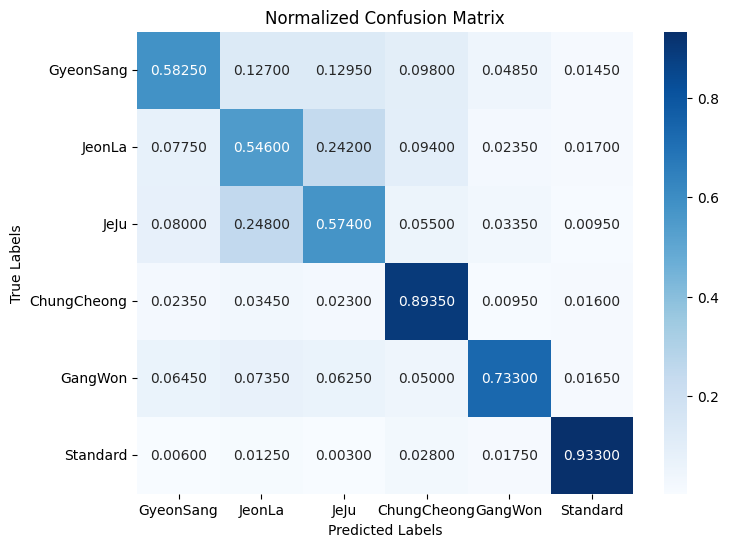

In [ ]:
# 오차 행렬 계산
cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(predict, axis=1))

# 오차 행렬을 0~1로 정규화
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# 오차 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.5f', cmap='Blues', xticklabels = class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.show()

In [ ]:
# 평가 지표 계산 및 출력
print("\nClassification Report of GRU:")
print(classification_report(np.argmax(Y_test, axis=1), np.argmax(predict, axis=1), target_names=class_labels))


Classification Report of GRU:
              precision    recall  f1-score   support

   GyeonSang       0.61      0.71      0.65      2000
      JeonLa       0.56      0.53      0.54      2000
        JeJu       0.57      0.58      0.58      2000
 ChungCheong       0.83      0.79      0.81      2000
     GangWon       0.82      0.75      0.78      2000
    Standard       0.93      0.93      0.93      2000

    accuracy                           0.71     12000
   macro avg       0.72      0.71      0.72     12000
weighted avg       0.72      0.71      0.72     12000



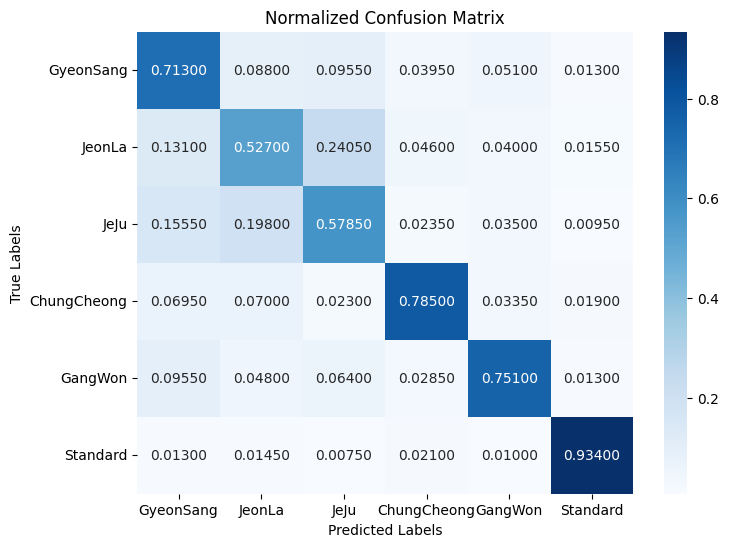

In [ ]:
# 오차 행렬 계산
cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(predict, axis=1))

# 오차 행렬을 0~1로 정규화
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# 오차 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.5f', cmap='Blues', xticklabels = class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.show()

In [ ]:
# 평가 지표 계산 및 출력
print("\nClassification Report of Bi-LSTM:")
print(classification_report(np.argmax(Y_test, axis=1), np.argmax(predict, axis=1), target_names=class_labels))


Classification Report of Bi-LSTM:
              precision    recall  f1-score   support

   GyeonSang       0.58      0.72      0.64      2000
      JeonLa       0.54      0.54      0.54      2000
        JeJu       0.59      0.49      0.53      2000
 ChungCheong       0.81      0.81      0.81      2000
     GangWon       0.83      0.73      0.78      2000
    Standard       0.90      0.94      0.92      2000

    accuracy                           0.71     12000
   macro avg       0.71      0.71      0.70     12000
weighted avg       0.71      0.71      0.70     12000



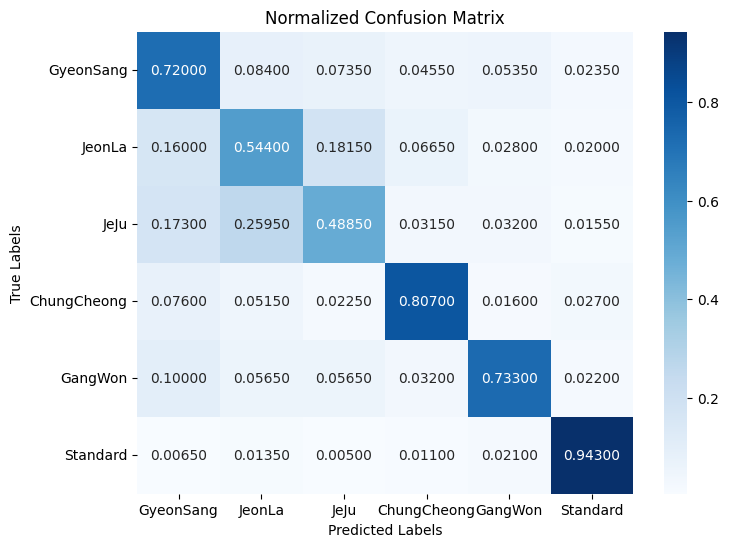

In [ ]:
# 오차 행렬 계산
cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(predict, axis=1))

# 오차 행렬을 0~1로 정규화
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# 오차 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.5f', cmap='Blues', xticklabels = class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.show()